# Regressions

In this file:

0. Regression of 30 industries, without environmental variables


1. Main Regressions


2. Running all regressions for all 3 events
    
    2.1 Dependent Variable: Env_Score3
    
    2.2 Dependent Variables: Env_Score1 + CI
    
    2.3 Different Event Window
    
    2.4 Different Estimation Window
        
    2.5 Winsorized
    
    2.6 Controlling for Corporate Governance
    

3. Long-term analysis regressions: graph

    3.1 With Rolling Estimation Window
    
    3.2 With Fixed Estimation Window
    
    3.3 R-squred analysis over long-run


4. Long-term analysis: Regressing Panel Data, CARs vs Trump's approval rate

    4.1 With Rolling Estimation Window
    
    4.2 With Fixed Estimation Window

In [1]:
import pandas as pd
import numpy as np

from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm

from linearmodels import PanelOLS

import matplotlib.pyplot as plt
from scipy import stats

In [2]:
Data = pd.read_excel("./Extractions.xlsx", sheet_name = "CAR_Final")

In [3]:
#To facilitate, naming these variables with long original names:
ci = 'Carbon_Intensity_2016'
ciP = 'Carbon_Intensity_2017'

In [4]:
#Adding Industry dummies: 12Ind

dummies_12Ind = pd.get_dummies(Data["FF_12Ind"])
dummy_12Ind_list = [*dummies_12Ind.iloc[:,0:-1].columns] #all except one
dummies_12Ind.sum()

01 - Consumer Non-Durables    108
02 - Consumer Durables         49
03 - Manufacturing            217
04 - Energy                    82
05 - Chemicals                 66
06 - Business Equipment       341
07 - Telecomunication          63
08 - Utilities                 76
09 - Shops                    247
10 - Healthcare               310
11 - Money                    651
12 - Other                    340
dtype: int64

In [5]:
#Adding Industry dummies: 30Ind
dummies_30Ind = pd.get_dummies(Data["FF_30Ind"])
dummy_30Ind_list = [*dummies_30Ind.iloc[:,0:-1].columns] #all except one
dummies_30Ind.sum()

01 - Food Products                                                  47
02 - Beer & Liquor                                                   8
03 - Tobacco Products                                                4
04 - Recreation                                                     39
05 - Printing and Publishing                                        22
06 - Consumer Goods                                                 42
07 - Apparel                                                        22
08 - Healthcare, Medical Equipment, Pharmaceutical Products        310
09 - Chemicals                                                      56
10 - Textiles                                                        5
11 - Construction and Construction Materials                        67
12 - Steel Works Etc                                                22
13 - Fabricated Products and Machinery                              80
14 - Electrical Equipment                                           23
15 - A

In [6]:
Data = Data.join(dummies_12Ind)
Data = Data.join(dummies_30Ind)

In [7]:
list(Data.columns)

['Firm',
 'DS_Code',
 'Cusip',
 'Sic',
 'Estimated CO2 Equivalents Emission Total - 2016',
 'Estimated CO2 Equivalents Emission Total - 2017',
 'Carbon_Intensity_2016',
 'Carbon_Intensity_2017',
 'Carbon_Intensity_2016_winsorized',
 'Carbon_Intensity_2017_winsorized',
 'Carbon_Intensity_2016_MV',
 'Carbon_Intensity_2017_MV',
 'Carbon_Intensity_2016_EBIT',
 'Carbon_Intensity_2017_EBIT',
 'Env_Score1',
 'Env_Score1d',
 'Env_Score1P',
 'Env_Score1dP',
 'Env_Score3',
 'Env_Score33',
 'Env_Score3P',
 'Env_Score_test',
 'Gov_Score',
 'Social_Score',
 'Env_Score3P.1',
 'Social_ScoreP',
 'NET INCOME - BASIC',
 'TOTAL ASSETS',
 'ROA',
 'INCOME TAXES',
 'EARNINGS BEF INTEREST & TAXES',
 'ETR',
 'CASH ETR',
 'EBIT & DEPRECIATION',
 'MARKET VALUE',
 'Log Market Cap',
 'TOTAL DEBT',
 "COMMON SHAREHOLDERS' EQUITY",
 'Leverage',
 'Debt_to_Equity',
 'NET SALES/REVENUES -1YR ANN GR',
 'FOREIGN SALES % TOTAL SALES',
 'Percent_Foreign_Revenues(Compustat)',
 'NET INCOME - BASIC_P',
 'TOTAL ASSETS_P',
 'RO

In [8]:
#The control variables are the following:
controls = ["CASH ETR","FOREIGN SALES % TOTAL SALES","Log Market Cap", "Leverage","ROA","NET SALES/REVENUES -1YR ANN GR"]
controlsp = ["CASH ETR","FOREIGN SALES % TOTAL SALES_P","Log Market Cap_P", "Leverage_P","ROA_P","NET SALES/REVENUES -1YR ANN GR_P"]

controlsw = ["CASH ETR_winsorized","FOREIGN SALES % TOTAL SALES_winsorized","Log Market Cap_winsorized", "Debt_to_Equity_winsorized","ROA_winsorized","NET SALES/REVENUES -1YR ANN GR_winsorized"]

In [9]:
#A list for all the events:
Event_windows = [*Data.loc[:, 'Trump_Raw_1d':'Paris_FF_ret_dec17'].columns]

#List exclusively for Trump and Scott Pruitt events:
Event_TS = Event_windows[0:36] 
#List exclusively for Paris event:
Event_Paris = Event_windows[-15:]
#Alternative list Paris and Scott: event windows different
Event_Paris2 = [*Data.loc[:,'Paris_Raw_3dd':'Paris_FF_ret_9dd']]
Event_Scott2 = [*Data.loc[:,"Scott_Raw_3dd": "Scott_FF_ret_9dd"]]

#Alternative list Paris and Scott: estimation windows different
Event_Paris3 = [*Data.loc[:,'Paris_CAPM_ret_1ddd':'Paris_FF_ret_10ddd']]
Event_Scott3 = [*Data.loc[:,'Scott_CAPM_ret_1ddd':'Scott_FF_ret_10ddd']]

In [10]:
Data.iloc[0:5,8:15]

,Carbon_Intensity_2016_winsorized,Carbon_Intensity_2017_winsorized,Carbon_Intensity_2016_MV,Carbon_Intensity_2017_MV,Carbon_Intensity_2016_EBIT,Carbon_Intensity_2017_EBIT,Env_Score1
0,0.067419,0.061057,0.011564,0.010473,0.216212,0.195810,0.320325
1,0.025305,0.025077,0.032807,0.032511,0.552924,0.547924,0.335031
2,0.017545,0.017040,0.024938,0.024220,0.189362,0.183911,0.337242
3,0.020452,0.021047,0.017581,0.018093,0.559111,0.575380,0.588039
4,0.008820,0.009229,0.006100,0.006383,0.063390,0.066326,0.543124


# Regressions

# 0. Industries only

In [11]:
controls = ["ROA","Log Market Cap", "Leverage","NET SALES/REVENUES -1YR ANN GR"]
reg1 = sm.OLS(endog= Data["Trump_CAPM_ret_1d"], exog= sm.add_constant(Data[controls + dummy_30Ind_list]), missing='drop').fit()
reg2 = sm.OLS(endog= Data["Trump_CAPM_ret_dec16"], exog= sm.add_constant(Data[controls + dummy_30Ind_list]), missing='drop').fit()
reg3 = sm.OLS(endog= Data["Scott_CAPM_ret_1d"], exog= sm.add_constant(Data[controls + dummy_30Ind_list]), missing='drop').fit()
reg4 = sm.OLS(endog= Data["Scott_CAPM_ret_dec16"], exog= sm.add_constant(Data[controls + dummy_30Ind_list]), missing='drop').fit()
reg5 = sm.OLS(endog= Data["Paris_CAPM_ret_1d"], exog= sm.add_constant(Data[controlsp + dummy_30Ind_list]), missing='drop').fit()
reg6 = sm.OLS(endog= Data["Paris_CAPM_ret_dec17"], exog= sm.add_constant(Data[controlsp + dummy_30Ind_list]), missing='drop').fit()

Industries_analysis = pd.DataFrame()

Industries_analysis["Trump_1d"] = reg1.params.iloc[5:]
Industries_analysis["Trump_dec16"] = reg2.params.iloc[5:]
Industries_analysis["Scott_1d"] = reg3.params.iloc[5:]
Industries_analysis["Scott_dec16"] = reg4.params.iloc[5:]
Industries_analysis["Paris_1d"] = reg5.params.iloc[5:]
Industries_analysis["Paris_dec17"] = reg6.params.iloc[5:]

Industries_analysis.to_excel("./real_industry_analysis.xlsx")

controls = ["CASH ETR","FOREIGN SALES % TOTAL SALES","Log Market Cap", "Leverage","ROA","NET SALES/REVENUES -1YR ANN GR"]

In [12]:
Industries_analysis

,Trump_1d,Trump_dec16,Scott_1d,Scott_dec16,Paris_1d,Paris_dec17
01 - Food Products,-0.007364,0.023306,0.011975,0.039056,0.002880,-0.041723
02 - Beer & Liquor,-0.006495,-0.019651,0.001338,0.021579,0.001356,0.079017
03 - Tobacco Products,0.000297,0.038286,0.027370,0.086161,0.004081,0.000064
04 - Recreation,0.003784,-0.011494,0.007907,-0.010964,-0.003417,0.023199
05 - Printing and Publishing,0.009023,0.003428,0.011824,-0.010823,-0.005014,-0.104207
06 - Consumer Goods,0.001155,-0.022899,0.002547,-0.013607,-0.004523,-0.042840
07 - Apparel,-0.005868,-0.105252,0.001702,-0.084399,-0.009415,0.153475
"08 - Healthcare, Medical Equipment, Pharmaceutical Products",0.027096,-0.035328,-0.019471,-0.025783,-0.000333,0.022562
09 - Chemicals,0.007982,0.022901,0.005635,-0.021107,-0.010279,-0.005094
10 - Textiles,0.012498,0.055463,0.011068,0.022683,-0.009635,-0.072121


# 1. Main Regression

1.1 Env_Score1

In [13]:
#Function for Main tables
def regression_table(Data, independent, ind = 30, CI = "n", control = "controls"):
    main = pd.DataFrame() #coefficients and pvalues
    r_main = pd.DataFrame() #Rsquared and Number observations per regression
    if ind== 12:
        ind = dummy_12Ind_list
    elif ind == 30:
        ind = dummy_30Ind_list
    
    if independent == "Env_Score1":
        independentp = "Env_Score1P"
    elif independent == "Env_Score3":
        independentp = "Env_Score3P"
    elif independent == "Env_Score33":
        independentp = "Env_Score3P"        
    
    if control == "controlsw":
        controlss = controlsw
        controlssp = controlsw
    else:
        controlss = controls
        controlssp = controlsp
    if CI == 'y':

        #main first
        reg1 = sm.OLS(endog= Data["Trump_CAPM_ret_1d"], exog= sm.add_constant(Data[[independent] +  [ci] + controlss + ind]), missing='drop').fit()
        reg2 = sm.OLS(endog= Data["Trump_CAPM_ret_5d"], exog= sm.add_constant(Data[[independent] + [ci] +  controlss + ind]), missing='drop').fit()
        reg3 = sm.OLS(endog= Data["Trump_CAPM_ret_10d"], exog= sm.add_constant(Data[[independent] + [ci] +  controlss + ind]), missing='drop').fit()
        reg4 = sm.OLS(endog= Data["Scott_CAPM_ret_1d"], exog= sm.add_constant(Data[[independent] + [ci] +  controlss + ind]), missing='drop').fit()
        reg5 = sm.OLS(endog= Data["Scott_CAPM_ret_5d"], exog= sm.add_constant(Data[[independent] + [ci] +  controlss + ind]), missing='drop').fit()
        reg6 = sm.OLS(endog= Data["Scott_CAPM_ret_10d"], exog= sm.add_constant(Data[[independent] + [ci] +  controlss + ind]), missing='drop').fit()
        reg7 = sm.OLS(endog= Data["Paris_CAPM_ret_1d"], exog= sm.add_constant(Data[[independentp] + [ciP] +  controlssp + ind]), missing='drop').fit()
        reg8 = sm.OLS(endog= Data["Paris_CAPM_ret_5d"], exog= sm.add_constant(Data[[independentp] + [ciP] +  controlssp + ind]), missing='drop').fit()
        reg9 = sm.OLS(endog= Data["Paris_CAPM_ret_10d"], exog= sm.add_constant(Data[[independentp] + [ciP] +  controlssp + ind]), missing='drop').fit()
    else:
        #main first
        reg1 = sm.OLS(endog= Data["Trump_CAPM_ret_1d"], exog= sm.add_constant(Data[[independent]  + controlss + ind]), missing='drop').fit()
        reg2 = sm.OLS(endog= Data["Trump_CAPM_ret_5d"], exog= sm.add_constant(Data[[independent] +  controlss + ind]), missing='drop').fit()
        reg3 = sm.OLS(endog= Data["Trump_CAPM_ret_10d"], exog= sm.add_constant(Data[[independent] + controlss + ind]), missing='drop').fit()
        reg4 = sm.OLS(endog= Data["Scott_CAPM_ret_1d"], exog= sm.add_constant(Data[[independent] + controlss + ind]), missing='drop').fit()
        reg5 = sm.OLS(endog= Data["Scott_CAPM_ret_5d"], exog= sm.add_constant(Data[[independent] + controlss + ind]), missing='drop').fit()
        reg6 = sm.OLS(endog= Data["Scott_CAPM_ret_10d"], exog= sm.add_constant(Data[[independent] + controlss + ind]), missing='drop').fit()
        reg7 = sm.OLS(endog= Data["Paris_CAPM_ret_1d"], exog= sm.add_constant(Data[[independentp] + controlssp + ind]), missing='drop').fit()
        reg8 = sm.OLS(endog= Data["Paris_CAPM_ret_5d"], exog= sm.add_constant(Data[[independentp] + controlssp + ind]), missing='drop').fit()
        reg9 = sm.OLS(endog= Data["Paris_CAPM_ret_10d"], exog= sm.add_constant(Data[[independentp] + controlssp + ind]), missing='drop').fit()       
        
    main["Trump1d"] = reg1.params
    main["Trump1d_pv"] = reg1.pvalues
    main['Trump5d'] = reg2.params
    main['Trump5d_pv'] = reg2.pvalues

    main['Trump10d'] = reg3.params
    main['Trump10d_pv'] = reg3.pvalues

    main['Scott1d'] = reg4.params
    main['Scott1d_pv'] = reg4.pvalues

    main['Scott5d'] = reg5.params
    main['Scott5d_pv'] = reg5.pvalues

    main['Scott10d'] = reg6.params
    main['Scott10d_pv'] = reg6.pvalues
    
    #adjusting index for Paris
    reg7_ = pd.DataFrame(reg7.params).set_index(reg1.params.index)
    reg8_ = pd.DataFrame(reg8.params).set_index(reg1.params.index)
    reg9_ = pd.DataFrame(reg9.params).set_index(reg1.params.index)
    
    reg7_p = pd.DataFrame(reg7.pvalues).set_index(reg1.params.index)
    reg8_p = pd.DataFrame(reg8.pvalues).set_index(reg1.params.index)
    reg9_p = pd.DataFrame(reg9.pvalues).set_index(reg1.params.index)

    

    main['Paris1d'] = reg7_
    main['Paris1d_pv'] = reg7_p

    main['Paris5d'] = reg8_
    main['Paris5d_pv'] = reg8_p

    main['Paris10d'] = reg9_
    main['Paris10d_pv'] = reg9_p

    #now get the rquares and N
    a = [reg1.nobs,reg1.nobs, reg2.nobs,reg2.nobs, reg3.nobs,reg3.nobs, reg4.nobs,reg4.nobs, reg5.nobs,reg5.nobs, reg6.nobs,reg6.nobs, reg7.nobs,reg7.nobs, reg8.nobs,reg8.nobs, reg9.nobs,reg9.nobs]
    b = [reg1.rsquared,reg1.rsquared, reg2.rsquared,reg2.rsquared, reg3.rsquared,reg3.rsquared, reg4.rsquared,reg4.rsquared, reg5.rsquared,reg5.rsquared, reg6.rsquared,reg6.rsquared, reg7.rsquared,reg7.rsquared, reg8.rsquared,reg8.rsquared, reg9.rsquared,reg9.rsquared]
    
    main.loc["N"] = a
    main.loc["Rsquared"] = b
    
    if CI == 'y':
        return main.loc[["const"]+[independent]+ [ci] +controls+["N","Rsquared"]]

    else:
        return main.loc[["const"]+[independent]+controls+["N","Rsquared"]]

In [14]:
#main regression, not including carbon intensity
regression_table(Data, "Env_Score1", 12).round(4)

,Trump1d,Trump1d_pv,Trump5d,Trump5d_pv,Trump10d,Trump10d_pv,Scott1d,Scott1d_pv,Scott5d,Scott5d_pv,Scott10d,Scott10d_pv,Paris1d,Paris1d_pv,Paris5d,Paris5d_pv,Paris10d,Paris10d_pv
const,0.0539,0.0000,0.1807,0.0000,0.2375,0.0000,-0.0119,0.0003,-0.0092,0.1473,0.0179,0.0320,0.0169,0.0000,0.0189,0.0004,0.0499,0.0000
Env_Score1,0.0112,0.4714,0.0664,0.0171,0.0817,0.0072,0.0274,0.0008,0.0525,0.0010,0.0540,0.0097,-0.0001,0.9838,-0.0164,0.2516,0.0283,0.1436
CASH ETR,0.0010,0.8649,0.0215,0.0331,0.0226,0.0402,-0.0012,0.6912,0.0021,0.7125,0.0050,0.5053,0.0011,0.6397,-0.0076,0.1162,0.0075,0.2549
FOREIGN SALES % TOTAL SALES,-0.0001,0.0157,-0.0002,0.0091,-0.0002,0.0255,-0.0000,0.0334,0.0001,0.0708,-0.0000,0.5241,-0.0001,0.0020,0.0000,0.3375,-0.0003,0.0000
Log Market Cap,-0.0047,0.0000,-0.0189,0.0000,-0.0265,0.0000,-0.0001,0.8210,-0.0028,0.0018,-0.0065,0.0000,-0.0014,0.0000,-0.0013,0.0703,-0.0056,0.0000
Leverage,-0.0199,0.0000,-0.0376,0.0000,-0.0376,0.0000,0.0031,0.1531,-0.0103,0.0140,-0.0123,0.0248,-0.0011,0.4859,0.0001,0.9706,-0.0050,0.2973
ROA,-0.0283,0.0024,-0.0952,0.0000,-0.0331,0.0679,0.0323,0.0000,0.0708,0.0000,0.0829,0.0000,0.0008,0.6911,0.0031,0.4906,0.0086,0.1535
NET SALES/REVENUES -1YR ANN GR,0.0000,0.6375,-0.0000,0.6115,0.0000,0.9088,-0.0000,0.0067,-0.0001,0.0020,-0.0001,0.0343,0.0000,0.6450,0.0000,0.0001,0.0000,0.0054
N,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1765.0000,1827.0000,1827.0000,1827.0000,1827.0000,1827.0000,1827.0000
Rsquared,0.1400,0.1400,0.2625,0.2625,0.2784,0.2784,0.1760,0.1760,0.0997,0.0997,0.1065,0.1065,0.0445,0.0445,0.0705,0.0705,0.1435,0.1435


Env_Score1 and CI

In [15]:
#second regression, including carbon intensity
regression_table(Data, "Env_Score33", 12 ,CI = 'y', control = "controlsw").round(3)

C:\Users\jlbgo\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


,Trump1d,Trump1d_pv,Trump5d,Trump5d_pv,Trump10d,Trump10d_pv,Scott1d,Scott1d_pv,Scott5d,Scott5d_pv,Scott10d,Scott10d_pv,Paris1d,Paris1d_pv,Paris5d,Paris5d_pv,Paris10d,Paris10d_pv
const,0.054,0.000,0.188,0.000,0.247,0.000,-0.009,0.004,-0.009,0.168,0.014,0.090,0.015,0.000,0.016,0.002,0.051,0.000
Env_Score33,0.001,0.832,0.017,0.101,0.023,0.039,0.002,0.462,0.004,0.530,-0.003,0.750,0.002,0.354,0.002,0.755,0.012,0.065
Carbon_Intensity_2016,0.005,0.050,0.002,0.642,0.001,0.925,0.002,0.173,-0.000,0.942,0.002,0.620,-0.001,0.390,0.003,0.201,0.002,0.642
CASH ETR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOREIGN SALES % TOTAL SALES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Log Market Cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Leverage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NET SALES/REVENUES -1YR ANN GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000,1742.000


Running only with carbon-intensity:

In [16]:
#Function for Main tables
def regression_table_ci(Data, ind = 12, control = "controls"):
    main = pd.DataFrame() #coefficients and pvalues
    r_main = pd.DataFrame() #Rsquared and Number observations per regression
    if ind== 12:
        ind = dummy_12Ind_list
    elif ind == 30:
        ind = dummy_30Ind_list
    
    

    #main first
    reg1 = sm.OLS(endog= Data["Trump_CAPM_ret_1d"], exog= sm.add_constant(Data[[ci] + controls + ind]), missing='drop').fit()
    reg2 = sm.OLS(endog= Data["Trump_CAPM_ret_5d"], exog= sm.add_constant(Data[[ci] +  controls + ind]), missing='drop').fit()
    reg3 = sm.OLS(endog= Data["Trump_CAPM_ret_10d"], exog= sm.add_constant(Data[[ci] +  controls + ind]), missing='drop').fit()
    reg4 = sm.OLS(endog= Data["Scott_CAPM_ret_1d"], exog= sm.add_constant(Data[[ci] +  controls + ind]), missing='drop').fit()
    reg5 = sm.OLS(endog= Data["Scott_CAPM_ret_5d"], exog= sm.add_constant(Data[[ci] +  controls + ind]), missing='drop').fit()
    reg6 = sm.OLS(endog= Data["Scott_CAPM_ret_10d"], exog= sm.add_constant(Data[[ci] +  controls + ind]), missing='drop').fit()
    reg7 = sm.OLS(endog= Data["Paris_CAPM_ret_1d"], exog= sm.add_constant(Data[[ciP] +  controlsp + ind]), missing='drop').fit()
    reg8 = sm.OLS(endog= Data["Paris_CAPM_ret_5d"], exog= sm.add_constant(Data[[ciP] +  controlsp + ind]), missing='drop').fit()
    reg9 = sm.OLS(endog= Data["Paris_CAPM_ret_10d"], exog= sm.add_constant(Data[[ciP] +  controlsp + ind]), missing='drop').fit()
  
    main["Trump1d"] = reg1.params
    main["Trump1d_pv"] = reg1.pvalues
    main['Trump5d'] = reg2.params
    main['Trump5d_pv'] = reg2.pvalues

    main['Trump10d'] = reg3.params
    main['Trump10d_pv'] = reg3.pvalues

    main['Scott1d'] = reg4.params
    main['Scott1d_pv'] = reg4.pvalues

    main['Scott5d'] = reg5.params
    main['Scott5d_pv'] = reg5.pvalues

    main['Scott10d'] = reg6.params
    main['Scott10d_pv'] = reg6.pvalues
    
    #adjusting index for Paris
    reg7_ = pd.DataFrame(reg7.params).set_index(reg1.params.index)
    reg8_ = pd.DataFrame(reg8.params).set_index(reg1.params.index)
    reg9_ = pd.DataFrame(reg9.params).set_index(reg1.params.index)
    
    reg7_p = pd.DataFrame(reg7.pvalues).set_index(reg1.params.index)
    reg8_p = pd.DataFrame(reg8.pvalues).set_index(reg1.params.index)
    reg9_p = pd.DataFrame(reg9.pvalues).set_index(reg1.params.index)

    

    main['Paris1d'] = reg7_
    main['Paris1d_pv'] = reg7_p

    main['Paris5d'] = reg8_
    main['Paris5d_pv'] = reg8_p

    main['Paris10d'] = reg9_
    main['Paris10d_pv'] = reg9_p

    #now get the rquares and N
    a = [reg1.nobs,reg1.nobs, reg2.nobs,reg2.nobs, reg3.nobs,reg3.nobs, reg4.nobs,reg4.nobs, reg5.nobs,reg5.nobs, reg6.nobs,reg6.nobs, reg7.nobs,reg7.nobs, reg8.nobs,reg8.nobs, reg9.nobs,reg9.nobs]
    b = [reg1.rsquared,reg1.rsquared, reg2.rsquared,reg2.rsquared, reg3.rsquared,reg3.rsquared, reg4.rsquared,reg4.rsquared, reg5.rsquared,reg5.rsquared, reg6.rsquared,reg6.rsquared, reg7.rsquared,reg7.rsquared, reg8.rsquared,reg8.rsquared, reg9.rsquared,reg9.rsquared]
    
    main.loc["N"] = a
    main.loc["Rsquared"] = b
    
    return main.loc[["const"] + [ci] +controls+["N","Rsquared"]]


In [17]:
regression_table_ci(Data)

,Trump1d,Trump1d_pv,Trump5d,Trump5d_pv,Trump10d,Trump10d_pv,Scott1d,Scott1d_pv,Scott5d,Scott5d_pv,Scott10d,Scott10d_pv,Paris1d,Paris1d_pv,Paris5d,Paris5d_pv,Paris10d,Paris10d_pv
const,0.051328,1.504342e-18,0.181661,9.000094e-62,2.398113e-01,7.050588e-88,-0.006990,2.171035e-02,0.000153,0.980127,0.029938,1.444914e-04,0.015477,3.576322e-10,0.013794,0.008820,0.053554,3.651457e-14
Carbon_Intensity_2016,0.006467,1.898483e-02,0.004281,3.944178e-01,3.097331e-03,5.693827e-01,0.001572,2.786829e-01,-0.000988,0.736131,0.000951,7.997800e-01,-0.000913,4.176856e-01,0.002847,0.238315,0.001332,6.788701e-01
CASH ETR,0.002391,6.713625e-01,0.023748,2.099754e-02,2.628421e-02,1.835371e-02,-0.000845,7.759348e-01,0.001975,0.741886,0.007059,3.573813e-01,0.000294,8.951423e-01,-0.007559,0.114291,0.004416,4.886661e-01
FOREIGN SALES % TOTAL SALES,-0.000097,1.758863e-02,-0.000174,2.017238e-02,-1.507554e-04,6.263827e-02,-0.000033,1.288230e-01,0.000107,0.014290,-0.000016,7.676492e-01,-0.000053,1.399709e-03,0.000015,0.669220,-0.000258,5.541222e-08
Log Market Cap,-0.004449,2.573371e-11,-0.016339,1.067075e-39,-2.351923e-02,1.780937e-66,0.000554,1.126909e-01,-0.001398,0.047578,-0.005443,1.935405e-09,-0.001268,5.545037e-06,-0.001615,0.006828,-0.004895,9.166956e-10
Leverage,-0.016483,4.385933e-05,-0.034999,2.018434e-06,-3.213074e-02,5.556247e-05,0.004070,5.498197e-02,-0.009082,0.034012,-0.010729,5.022965e-02,-0.000016,9.922567e-01,-0.000172,0.960397,-0.004911,2.888753e-01
ROA,-0.012312,1.375870e-01,-0.052149,5.760302e-04,-1.035771e-02,5.271927e-01,0.024257,3.153891e-08,0.037701,0.000020,0.055613,8.919684e-07,-0.007752,4.775449e-02,0.008300,0.322678,0.002519,8.217941e-01
NET SALES/REVENUES -1YR ANN GR,0.000012,6.581528e-01,-0.000030,5.457996e-01,-6.234230e-08,9.990770e-01,-0.000039,6.385974e-03,-0.000099,0.000677,-0.000088,1.845619e-02,-0.000010,7.022449e-02,0.000009,0.447704,0.000002,9.053479e-01
N,1835.000000,1.835000e+03,1835.000000,1.835000e+03,1.835000e+03,1.835000e+03,1835.000000,1.835000e+03,1835.000000,1835.000000,1835.000000,1.835000e+03,1751.000000,1.751000e+03,1751.000000,1751.000000,1751.000000,1.751000e+03
Rsquared,0.130968,1.309682e-01,0.238354,2.383545e-01,2.658785e-01,2.658785e-01,0.157213,1.572125e-01,0.069210,0.069210,0.097225,9.722544e-02,0.048513,4.851310e-02,0.068815,0.068815,0.158376,1.583761e-01


# 2. Running all

2.1 Running for Env_Score3

In [18]:
#Dataframe where all regression outputs will be inserted:
all_regressions3 = pd.DataFrame(Event_windows)
all_regressions3["12_Ind"] = np.nan
all_regressions3["12_Ind_p-value"] = np.nan
all_regressions3["30_Ind"] = np.nan
all_regressions3["30_Ind_p-value"] = np.nan

all_regressions3.set_index(0, drop = True, inplace = True)

In [19]:
#Run all regressions
#Creating list with the results
coef12 = list()
p_value12 = list()

coef30 = list()
p_value30 = list()

# Running for Donald Trump and Scott Pruitt events:
for event in Event_TS:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score33"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score33"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score33"] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score33"])


for event in Event_TS:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score33"] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score33"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score33"] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score33"])

#Running for Paris event:    

for event in Event_Paris:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score3P"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score3P"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score3P"] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score3P"])


for event in Event_Paris:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score3P"] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score3P"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score3P"] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score3P"])

    

#Appending the values to regression table
#Appending the values to regression table

all_regressions3.reset_index(inplace = True, drop = False)

all_regressions3["12_Ind"] = pd.DataFrame(coef12)
all_regressions3["12_Ind_p-value"] = pd.DataFrame(p_value12)

all_regressions3["30_Ind"] = pd.DataFrame(coef30)
all_regressions3["30_Ind_p-value"] = pd.DataFrame(p_value30)

all_regressions3.set_index(0,inplace = True, drop = True)

In [20]:
all_regressions3

,12_Ind,12_Ind_p-value,30_Ind,30_Ind_p-value
0,,,,
Trump_Raw_1d,0.001511,0.794923,0.000585,0.920323
Trump_Raw_3d,0.010947,0.259964,0.010086,0.303605
Trump_Raw_5d,0.019008,0.072334,0.017828,0.094021
Trump_Raw_10d,0.024018,0.037813,0.020916,0.071905
Trump_Raw_dec16,0.029391,0.078280,0.026540,0.113209
Trump_Raw_dec17,0.021104,0.642377,0.021741,0.635656
Trump_CAPM_ret_1d,0.001655,0.769922,0.000643,0.910289
Trump_CAPM_ret_3d,0.011141,0.239689,0.010163,0.288642
Trump_CAPM_ret_5d,0.019302,0.057045,0.017946,0.079751


In [21]:
all_regressions3.loc["Paris_CAPM_ret_1d": "Paris_CAPM_ret_10d"]

,12_Ind,12_Ind_p-value,30_Ind,30_Ind_p-value
0,,,,
Paris_CAPM_ret_1d,0.002019,0.375706,0.001748,0.447321
Paris_CAPM_ret_3d,0.001459,0.688779,0.002611,0.477419
Paris_CAPM_ret_5d,-0.003695,0.451010,-0.002257,0.646631
Paris_CAPM_ret_10d,0.009017,0.173498,0.011970,0.071808


2.2) Running for Env_Score1 + CI

In [22]:
#Dataframe where all regression outputs will be inserted:
all_regressionsci = pd.DataFrame(Event_windows)
all_regressionsci["12_Ind_env"] = np.nan
all_regressionsci["12_Ind_p-value_env"] = np.nan
all_regressionsci["12_Ind_ci"] = np.nan
all_regressionsci["12_Ind_p-value_ci"] = np.nan

all_regressionsci["30_Ind_env"] = np.nan
all_regressionsci["30_Ind_p-value_env"] = np.nan
all_regressionsci["30_Ind_ci"] = np.nan
all_regressionsci["30_Ind_p-value_ci"] = np.nan

all_regressionsci.set_index(0, drop = True, inplace = True)

In [23]:
#Run all regressions
#Creating list with the results
coef12_env = list()
p_value12_env = list()
coef12_ci = list()
p_value12_ci = list()


coef30_env = list()
p_value30_env = list()
coef30_ci = list()
p_value30_ci = list()


# Running for Donald Trump and Scott Pruitt events:
for event in Event_TS:
    coef12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ci]] ), missing='drop').fit().params.loc["Env_Score1"])
    p_value12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ci]]), missing='drop').fit().pvalues.loc["Env_Score1"])


for event in Event_TS:
    coef30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ci]]), missing='drop').fit().params.loc["Env_Score1"])
    p_value30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ci]]), missing='drop').fit().pvalues.loc["Env_Score1"])


for event in Event_TS:
    coef12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ci]]), missing='drop').fit().params.loc[ci])
    p_value12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ci]]), missing='drop').fit().pvalues.loc[ci])    
    

for event in Event_TS:
    coef30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ci]]), missing='drop').fit().params.loc[ci])
    p_value30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ci]]), missing='drop').fit().pvalues.loc[ci])

    
#Running for Paris event:    
for event in Event_Paris:
    coef12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciP] ]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciP]]), missing='drop').fit().pvalues.loc["Env_Score1P"])


for event in Event_Paris:
    coef30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciP]]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciP]]), missing='drop').fit().pvalues.loc["Env_Score1P"])


for event in Event_Paris:
    coef12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciP]]), missing='drop').fit().params.loc[ciP])
    p_value12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciP]]), missing='drop').fit().pvalues.loc[ciP])    
    

for event in Event_Paris:
    coef30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciP]]), missing='drop').fit().params.loc[ciP])
    p_value30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciP]]), missing='drop').fit().pvalues.loc[ciP])

    

#Appending the values to regression table
#Appending the values to regression table

all_regressionsci.reset_index(inplace = True, drop = False)

all_regressionsci["12_Ind_env"] = pd.DataFrame(coef12_env)
all_regressionsci["12_Ind_p-value_env"] = pd.DataFrame(p_value12_env)
all_regressionsci["12_Ind_ci"] = pd.DataFrame(coef12_ci)
all_regressionsci["12_Ind_p-value_ci"] = pd.DataFrame(p_value12_ci)


all_regressionsci["30_Ind_env"] = pd.DataFrame(coef30_env)
all_regressionsci["30_Ind_p-value_env"] = pd.DataFrame(p_value30_env)
all_regressionsci["30_Ind_ci"] = pd.DataFrame(coef30_ci)
all_regressionsci["30_Ind_p-value_ci"] = pd.DataFrame(p_value30_ci)

all_regressionsci.set_index(0,inplace = True, drop = True)

In [24]:
sm.OLS(endog= Data['Paris_CAPM_ret_1d'], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciP]]), missing='drop').fit().params.loc[ciP]

-0.0010010069766565577

In [25]:
all_regressionsci

,12_Ind_env,12_Ind_p-value_env,12_Ind_ci,12_Ind_p-value_ci,30_Ind_env,30_Ind_p-value_env,30_Ind_ci,30_Ind_p-value_ci
0,,,,,,,,
Trump_Raw_1d,0.011354,0.474710,0.005703,0.039054,0.010309,0.523826,0.003967,0.158767
Trump_Raw_3d,0.070251,0.009255,0.001554,0.740297,0.067274,0.014669,0.001382,0.773164
Trump_Raw_5d,0.065332,0.026277,0.002577,0.613905,0.051284,0.086859,0.000365,0.944102
Trump_Raw_10d,0.077060,0.016692,0.000900,0.872133,0.067924,0.038127,-0.001657,0.771209
Trump_Raw_dec16,0.185271,0.000069,0.004202,0.602735,0.159438,0.000741,0.003287,0.688880
Trump_Raw_dec17,0.124001,0.329094,0.025108,0.255796,0.118669,0.360582,0.043191,0.055960
Trump_CAPM_ret_1d,0.015745,0.308324,0.005588,0.037694,0.015323,0.331011,0.004098,0.135228
Trump_CAPM_ret_3d,0.076146,0.003812,0.001400,0.759349,0.074005,0.005986,0.001558,0.739185
Trump_CAPM_ret_5d,0.074265,0.008434,0.002344,0.632223,0.061484,0.032861,0.000633,0.899454


2.3) Running Alternative Event Window for Scott and Paris

In [26]:
#Dataframe where all regression outputs will be inserted:
all_regressionsPS = pd.DataFrame(Event_Scott2 + Event_Paris2)
all_regressionsPS["12_Ind"] = np.nan
all_regressionsPS["12_Ind_p-value"] = np.nan
all_regressionsPS["30_Ind"] = np.nan
all_regressionsPS["30_Ind_p-value"] = np.nan

all_regressionsPS.set_index(0, drop = True, inplace = True)

In [27]:
#Run all regressions
#Creating list with the results
coef12 = list()
p_value12 = list()

coef30 = list()
p_value30 = list()


#Running for Scott Pruitt:

for event in Event_Scott2:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1"])


for event in Event_Scott2:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score1"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1"])

#Running for Paris:

for event in Event_Paris2:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1P"])


for event in Event_Paris2:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1P"])

#Appending the values to regression table
#Appending the values to regression table

all_regressionsPS.reset_index(inplace = True, drop = False)

all_regressionsPS["12_Ind"] = pd.DataFrame(coef12)
all_regressionsPS["12_Ind_p-value"] = pd.DataFrame(p_value12)

all_regressionsPS["30_Ind"] = pd.DataFrame(coef30)
all_regressionsPS["30_Ind_p-value"] = pd.DataFrame(p_value30)

all_regressionsPS.set_index(0,inplace = True, drop = True)


In [28]:
all_regressionsPS

,12_Ind,12_Ind_p-value,30_Ind,30_Ind_p-value
0,,,,
Scott_Raw_3dd,0.030451,0.006811,0.026542,0.020298
Scott_Raw_5dd,0.026266,0.111888,0.020548,0.220099
Scott_Raw_9dd,0.092885,0.000006,0.085149,0.000052
Scott_CAPM_ret_3dd,0.036056,0.001547,0.032602,0.004927
Scott_CAPM_ret_5dd,0.035447,0.032625,0.030474,0.071207
Scott_CAPM_ret_9dd,0.034802,0.035499,0.029778,0.077169
Scott_FF_ret_3dd,0.028463,0.012855,0.025607,0.027974
Scott_FF_ret_5dd,0.021296,0.234085,0.020190,0.268330
Scott_FF_ret_9dd,0.065416,0.002610,0.062318,0.004891


2.4) Different estimation window for Scott and Paris

In [29]:
all_regressionsPS2 = pd.DataFrame(Event_Scott3 + Event_Paris3)
all_regressionsPS2["12_Ind"] = np.nan
all_regressionsPS2["12_Ind_p-value"] = np.nan
all_regressionsPS2["30_Ind"] = np.nan
all_regressionsPS2["30_Ind_p-value"] = np.nan

all_regressionsPS2.set_index(0, drop = True, inplace = True)

In [30]:
#Run all regressions
#Creating list with the results
coef12 = list()
p_value12 = list()

coef30 = list()
p_value30 = list()


#Running for Scott Pruitt:

for event in Event_Scott3:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1"])


for event in Event_Scott3:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score1"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1"])

#Running for Paris:

for event in Event_Paris3:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1P"])


for event in Event_Paris3:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1P"])

#Appending the values to regression table
#Appending the values to regression table

all_regressionsPS2.reset_index(inplace = True, drop = False)

all_regressionsPS2["12_Ind"] = pd.DataFrame(coef12)
all_regressionsPS2["12_Ind_p-value"] = pd.DataFrame(p_value12)

all_regressionsPS2["30_Ind"] = pd.DataFrame(coef30)
all_regressionsPS2["30_Ind_p-value"] = pd.DataFrame(p_value30)

all_regressionsPS2.set_index(0,inplace = True, drop = True)


In [31]:
all_regressionsPS2

,12_Ind,12_Ind_p-value,30_Ind,30_Ind_p-value
0,,,,
Scott_CAPM_ret_1ddd,0.027468,0.000753,0.025670,0.001995
Scott_CAPM_ret_3ddd,0.042155,0.001484,0.043747,0.001168
Scott_CAPM_ret_5ddd,0.052684,0.000989,0.048728,0.002531
Scott_CAPM_ret_10ddd,0.054228,0.009534,0.046737,0.025696
Scott_FF_ret_1ddd,0.023432,0.003614,0.021633,0.008404
Scott_FF_ret_3ddd,0.030098,0.025358,0.033213,0.014823
Scott_FF_ret_5ddd,0.046742,0.002779,0.042557,0.007017
Scott_FF_ret_10ddd,0.043752,0.036707,0.037129,0.076568
Paris_CAPM_ret_1ddd,-0.000136,0.983776,-0.001017,0.881587


2.5) Winsorized data

In [32]:
ciw = "Carbon_Intensity_2016_winsorized"
ciw17 = "Carbon_Intensity_2017_winsorized"

In [33]:
#Dataframe where all regression outputs will be inserted:
all_regressionsw = pd.DataFrame(Event_windows)
all_regressionsw["12_Ind_env"] = np.nan
all_regressionsw["12_Ind_p-value_env"] = np.nan
all_regressionsw["12_Ind_ci"] = np.nan
all_regressionsw["12_Ind_p-value_ci"] = np.nan

all_regressionsw["30_Ind_env"] = np.nan
all_regressionsw["30_Ind_p-value_env"] = np.nan
all_regressionsw["30_Ind_ci"] = np.nan
all_regressionsw["30_Ind_p-value_ci"] = np.nan

all_regressionsw.set_index(0, drop = True, inplace = True)

#winsorized carbon intensity
ciw = "Carbon_Intensity_2016_winsorized"
ciw17 = "Carbon_Intensity_2017_winsorized"

In [34]:
#Run all regressions
#Creating list with the results
coef12_env = list()
p_value12_env = list()
coef12_ci = list()
p_value12_ci = list()


coef30_env = list()
p_value30_env = list()
coef30_ci = list()
p_value30_ci = list()


# Running for Donald Trump and Scott Pruitt events:
for event in Event_TS:
    coef12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ciw]] ), missing='drop').fit().params.loc["Env_Score1"])
    p_value12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ciw]]), missing='drop').fit().pvalues.loc["Env_Score1"])


for event in Event_TS:
    coef30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ciw]]), missing='drop').fit().params.loc["Env_Score1"])
    p_value30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ciw]]), missing='drop').fit().pvalues.loc["Env_Score1"])


for event in Event_TS:
    coef12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ciw]]), missing='drop').fit().params.loc[ciw])
    p_value12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list + [ciw]]), missing='drop').fit().pvalues.loc[ciw])    
    

for event in Event_TS:
    coef30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ciw]]), missing='drop').fit().params.loc[ciw])
    p_value30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_30Ind_list + [ciw]]), missing='drop').fit().pvalues.loc[ciw])

    
#Running for Paris event:    
for event in Event_Paris:
    coef12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciw17] ]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value12_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciw17]]), missing='drop').fit().pvalues.loc["Env_Score1P"])


for event in Event_Paris:
    coef30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciw17]]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value30_env.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciw17]]), missing='drop').fit().pvalues.loc["Env_Score1P"])


for event in Event_Paris:
    coef12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciw17]]), missing='drop').fit().params.loc[ciw17])
    p_value12_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_12Ind_list + [ciw17]]), missing='drop').fit().pvalues.loc[ciw17])    
    

for event in Event_Paris:
    coef30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciw17]]), missing='drop').fit().params.loc[ciw17])
    p_value30_ci.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controlsp+["Env_Score1P"] + dummy_30Ind_list + [ciw17]]), missing='drop').fit().pvalues.loc[ciw17])

    

#Appending the values to regression table
#Appending the values to regression table

all_regressionsw.reset_index(inplace = True, drop = False)

all_regressionsw["12_Ind_env"] = pd.DataFrame(coef12_env)
all_regressionsw["12_Ind_p-value_env"] = pd.DataFrame(p_value12_env)
all_regressionsw["12_Ind_ci"] = pd.DataFrame(coef12_ci)
all_regressionsw["12_Ind_p-value_ci"] = pd.DataFrame(p_value12_ci)


all_regressionsw["30_Ind_env"] = pd.DataFrame(coef30_env)
all_regressionsw["30_Ind_p-value_env"] = pd.DataFrame(p_value30_env)
all_regressionsw["30_Ind_ci"] = pd.DataFrame(coef30_ci)
all_regressionsw["30_Ind_p-value_ci"] = pd.DataFrame(p_value30_ci)

all_regressionsw.set_index(0,inplace = True, drop = True)

In [35]:
all_regressionsw

,12_Ind_env,12_Ind_p-value_env,12_Ind_ci,12_Ind_p-value_ci,30_Ind_env,30_Ind_p-value_env,30_Ind_ci,30_Ind_p-value_ci
0,,,,,,,,
Trump_Raw_1d,0.009331,0.557348,0.013218,0.005055,0.009540,0.555391,0.009379,0.065712
Trump_Raw_3d,0.069128,0.010602,0.005421,0.498246,0.066791,0.015473,0.004346,0.616582
Trump_Raw_5d,0.062818,0.032942,0.011069,0.204269,0.050799,0.090133,0.002939,0.755396
Trump_Raw_10d,0.075369,0.019490,0.006459,0.498765,0.068134,0.037688,-0.003362,0.744539
Trump_Raw_dec16,0.180697,0.000106,0.019564,0.155653,0.158651,0.000794,0.008523,0.566435
Trump_Raw_dec17,0.118418,0.352364,0.047607,0.206858,0.114658,0.377394,0.080295,0.049721
Trump_CAPM_ret_1d,0.013864,0.370323,0.012632,0.005899,0.014519,0.357170,0.009740,0.049882
Trump_CAPM_ret_3d,0.075213,0.004347,0.004634,0.552573,0.073474,0.006394,0.004831,0.568686
Trump_CAPM_ret_5d,0.072039,0.010756,0.009877,0.237388,0.060927,0.034615,0.003674,0.685528


2.6) Controling for Corporate Governance and Social Responsibility

In [36]:
#Dataframe where all regression outputs will be inserted:
all_regressionscg = pd.DataFrame(Event_windows)
all_regressionscg["12_Ind"] = np.nan
all_regressionscg["12_Ind_p-value"] = np.nan
all_regressionscg["30_Ind"] = np.nan
all_regressionscg["30_Ind_p-value"] = np.nan

all_regressionscg.set_index(0, drop = True, inplace = True)

In [37]:
#Run all regressions
#Creating list with the results
coef12 = list()
p_value12 = list()

coef30 = list()
p_value30 = list()

# Running for Donald Trump and Scott Pruitt events:
for event in Event_TS:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + ['Governance Pillar Score', 'Social Pillar Score'] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1"])


for event in Event_TS:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"] + ['Governance Pillar Score', 'Social Pillar Score'] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score1"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1"]+ ['Governance Pillar Score', 'Social Pillar Score'] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1"])

#Running for Paris event:    

for event in Event_Paris:
    coef12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1P"] + ['Governance Pillar Score', 'Social Pillar Score'] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value12.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1P"] + ['Governance Pillar Score', 'Social Pillar Score'] + dummy_12Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1P"])


for event in Event_Paris:
    coef30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1P"] + ['Governance Pillar Score', 'Social Pillar Score'] + dummy_30Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])
    p_value30.append(sm.OLS(endog= Data[event], exog= sm.add_constant(Data[controls+["Env_Score1P"] + ['Governance Pillar Score', 'Social Pillar Score'] + dummy_30Ind_list]), missing='drop').fit().pvalues.loc["Env_Score1P"])

    

#Appending the values to regression table
#Appending the values to regression table

all_regressionscg.reset_index(inplace = True, drop = False)

all_regressionscg["12_Ind"] = pd.DataFrame(coef12)
all_regressionscg["12_Ind_p-value"] = pd.DataFrame(p_value12)

all_regressionscg["30_Ind"] = pd.DataFrame(coef30)
all_regressionscg["30_Ind_p-value"] = pd.DataFrame(p_value30)

all_regressionscg.set_index(0,inplace = True, drop = True)

In [38]:
all_regressionscg

,12_Ind,12_Ind_p-value,30_Ind,30_Ind_p-value
0,,,,
Trump_Raw_1d,-0.008795,0.684251,-0.011453,0.565755
Trump_Raw_3d,0.028200,0.028825,0.026712,0.423622
Trump_Raw_5d,0.022897,0.050365,0.004040,0.911227
Trump_Raw_10d,0.029737,0.032942,0.024679,0.532403
Trump_Raw_dec16,0.121403,0.000130,0.086109,0.130020
Trump_Raw_dec17,0.044128,0.415802,0.029241,0.851957
Trump_CAPM_ret_1d,-0.001662,0.471371,-0.003734,0.847785
Trump_CAPM_ret_3d,0.037776,0.012957,0.037074,0.255626
Trump_CAPM_ret_5d,0.037407,0.017097,0.019741,0.571171


# 3. Long Term Analysis Regressions

## 3.1 Long Run with rolling window

In [39]:
#Let's import the CAR Long Run file:
CAR_longrun = pd.read_excel("./CAR_longrun.xlsx")

In [40]:
CAR_longrun.head()

,AAON,AAR,AARON'S,ABBOTT LABORATORIES,ABBVIE,ABEONA THERAPEUTICS,ABERCROMBIE & FITCH 'A',ABIOMED,ABM INDS.,ABRAXAS PETROLEUM,...,CHECK POINT SFTW.TECHS.,CTRIP.COM INTL.ADR 8:1,JD.COM 'A' ADR 1:2,LIBERTY GLOBAL CL.A,LIBERTY GLOBAL SR.C,MERCADOLIBRE,NETEASE ADR 1:25,NXP SEMICONDUCTORS,SEAGATE TECH.,TE CONNECTIVITY
2016-11-09,0.034117,0.026105,0.003210,-0.010026,0.051723,0.125572,0.011530,-0.036293,0.012514,0.068625,...,0.005028,-0.049787,-0.030876,-0.024880,-0.027473,-0.031962,-0.002855,-0.041446,-0.017906,-0.008152
2016-11-10,0.015551,0.013039,0.012768,0.009947,0.018763,-0.021961,0.038602,0.007469,0.026529,-0.012778,...,0.001841,-0.035470,-0.033557,-0.073703,-0.062185,-0.062736,-0.095482,-0.012348,0.034914,0.008632
2016-11-11,0.057966,0.015703,0.024363,-0.013605,-0.015721,0.071860,0.035412,0.023395,0.010774,-0.009685,...,-0.009763,0.000378,-0.016668,-0.011853,-0.012167,-0.044736,0.024188,0.008849,0.026616,-0.000202
2016-11-14,0.023943,0.023856,0.015223,-0.025782,-0.003997,0.143645,0.022625,-0.002746,0.022089,0.018507,...,-0.006066,-0.014691,-0.016508,-0.002342,0.001567,-0.018917,-0.073219,-0.013573,0.016399,-0.004898
2016-11-15,-0.031976,-0.009634,-0.008797,0.006563,-0.008950,-0.040707,-0.051499,0.003846,0.009650,0.032923,...,-0.022644,0.023064,0.103542,-0.007085,-0.004810,0.002338,0.038544,-0.002119,-0.000720,-0.001936


In [41]:
#Let's import the controls + Env_Score for 2018
Data2 = pd.read_excel("./Extractions.xlsx", sheet_name = "controls2018")

In [42]:
Data2 = Data2.join(dummies_12Ind)

In [43]:
#Create DataFrame to insert all the regressions
longrun_reg = pd.DataFrame(index = CAR_longrun.index, columns = ["Regression"])

In [44]:
longrun_reg.head()

,Regression
2016-11-09,NaN
2016-11-10,NaN
2016-11-11,NaN
2016-11-14,NaN
2016-11-15,NaN


In [45]:
#setting controls, now with debt/equity
controls = ["ROA","CASH ETR","Log Market Cap", "Debt_to_Equity","NET SALES/REVENUES -1YR ANN GR","FOREIGN SALES % TOTAL SALES","Foreign_Sales_dummy"]
controlsp = ["ROA_P","CASH ETR","Log Market Cap_P", "Debt_to_Equity_P","NET SALES/REVENUES -1YR ANN GR_P","FOREIGN SALES % TOTAL SALES_P","Foreign_Sales_dummy_P"]

In [46]:
#setting the Index of Data to equal the one for longrun_reg:

Data.set_index("Firm", inplace = True)
Data2.set_index("Firm", inplace = True)

In [47]:
regressions = list()

for dia in longrun_reg.loc[:"2016-12-31"].index:
    regressions.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])


for dia in longrun_reg.loc["2017-01-01":"2017-12-31"].index:
    regressions.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])


for dia in longrun_reg.loc["2018-01-01":].index:
    regressions.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data2[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])



#Inserting the reseults in the regressions DataFrame
longrun_reg["Regression"] = pd.DataFrame(regressions, index = longrun_reg.index)

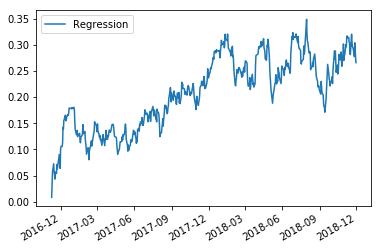

In [48]:
longrun_reg.loc[:"2018-12-02"].cumsum().plot()

In [49]:
nobs = list()

for dia in longrun_reg.loc[:"2016-12-31"].index:
    nobs.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().nobs)


for dia in longrun_reg.loc["2017-01-01":"2017-12-31"].index:
    nobs.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().nobs)


for dia in longrun_reg.loc["2018-01-01":].index:
    nobs.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data2[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().nobs)



#Inserting the reseults in the regressions DataFrame
longrun_reg_nobs = pd.DataFrame(index = longrun_reg.index)
longrun_reg_nobs["Regression"] = pd.DataFrame(nobs, longrun_reg.index)

In [50]:
longrun_reg_nobs.mean()

Regression    1835.752924
dtype: float64

In [51]:
#longrun_reg.loc[:"2018-12-02"].cumsum().to_excel("./longtermgraph.xlsx")

## 3.2 Long Run with fixed window

In [52]:
#Let's import the CAR Long Run file:
CAR_longrun2 = pd.read_excel("./CAR_longrun2.xlsx")

In [53]:
len(CAR_longrun2)

684

In [54]:
#Create DataFrame to insert all the regressions
longrun_reg2 = pd.DataFrame(index = CAR_longrun2.index, columns = ["Regression"])

#Test test test
regressions = list()

for dia in longrun_reg2.loc[:"2016-12-31"].index:
    regressions.append(sm.OLS(endog= CAR_longrun2.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])


for dia in longrun_reg2.loc["2017-01-01":"2017-12-31"].index:
       regressions.append(sm.OLS(endog= CAR_longrun2.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1P"])


for dia in longrun_reg2.loc["2018-01-01":].index:
       regressions.append(sm.OLS(endog= CAR_longrun2.loc[dia], exog= sm.add_constant(Data2[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])



#Inserting the reseults in the regressions DataFrame
longrun_reg2["Regression"] = pd.DataFrame(regressions, index = longrun_reg2.index)

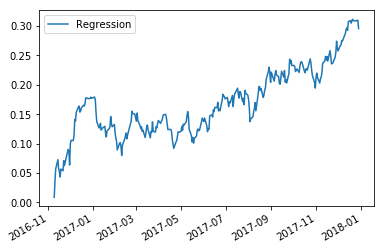

In [55]:
longrun_reg2.loc[:"2017-12-31"].cumsum().plot()

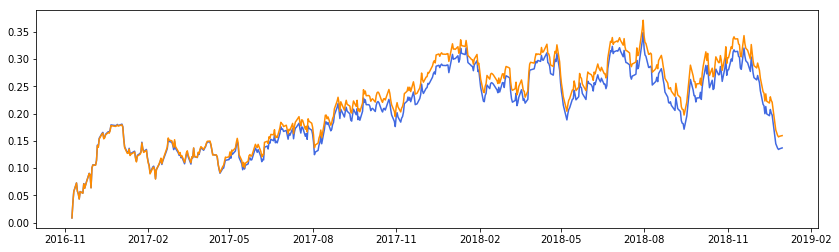

In [56]:
#Comparing Fixed window versus Rolling window (Estimation Window)

plt.figure(figsize=(14,4))

x1 = longrun_reg.loc[:"2018-12-31"].cumsum().index
y1 = longrun_reg.loc[:"2018-12-31"].cumsum()

x2= longrun_reg2.loc[:"2018-12-31"].cumsum().index
y2 = longrun_reg2.loc[:"2018-12-31"].cumsum()

fig1= plt.plot(x1,y1,"royalblue")
fig2= plt.plot(x2,y2,"darkorange")


## 3.3 Long run exactly like the paper

In [57]:
#Create DataFrame to insert all the regressions
longrun_reg3 = pd.DataFrame(index = CAR_longrun2.index, columns = ["Regression"])

#Test test test
regressions = list()

for dia in longrun_reg3.loc[:].index:
    regressions.append(sm.OLS(endog= CAR_longrun2.cumsum().loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().params.loc["Env_Score1"])


#Inserting the reseults in the regressions DataFrame
longrun_reg3["Regression"] = pd.DataFrame(regressions, index = longrun_reg3.index)

In [58]:
longrun_reg3.to_excel("./longrunnewwww.xlsx")

## R-squared over the long run

In [59]:
rsquare_lr = list()

for dia in longrun_reg.loc[:"2016-12-31"].index:
    rsquare_lr.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().rsquared)


for dia in longrun_reg.loc["2017-01-01":"2017-12-31"].index:
    rsquare_lr.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data[controls+["Env_Score1P"] + dummy_12Ind_list]), missing='drop').fit().rsquared)


for dia in longrun_reg.loc["2018-01-01":].index:
    rsquare_lr.append(sm.OLS(endog= CAR_longrun.loc[dia], exog= sm.add_constant(Data2[controls+["Env_Score1"] + dummy_12Ind_list]), missing='drop').fit().rsquared)



#Inserting the reseults in the regressions DataFrame
rsquare = pd.DataFrame(index = longrun_reg.index)
rsquare["R_square"] = pd.DataFrame(rsquare_lr, index = longrun_reg.index)

In [60]:
rsquare["R_square"].nlargest(10)

2017-06-09    0.378708
2016-11-30    0.354954
2017-11-29    0.330209
2017-12-04    0.285152
2019-04-17    0.268426
2017-07-03    0.265090
2017-03-21    0.261705
2018-10-12    0.251851
2017-06-21    0.248435
2016-12-01    0.247588
Name: R_square, dtype: float64

In [61]:
len(rsquare)

684

In [62]:
rsquare["R_square"].skew()

1.4891037982869564

In [63]:
rsquare.to_excel("./r-squared.xlsx")

In [64]:
rsquare.loc[:"2018-12-31"].median()

R_square    0.081376
dtype: float64

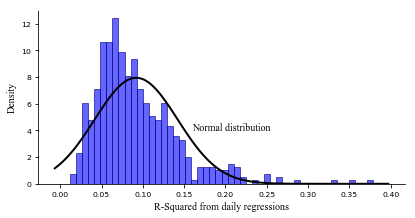

In [65]:
# Histogram
fig, ax = plt.subplots()
plt.hist(rsquare["R_square"].loc[:"2018-12-31"], bins=50, density=True, alpha=0.6, color="b", edgecolor = "navy")
## Consistent with np.histogram.

csfont = {'fontname':'Times New Roman','size': 10} #setting font to Times New Roman, size 10


# Normal curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x,
                   rsquare.mean(),
                   rsquare.std())
plt.plot(x, p, 'k', linewidth=2)

# Other definitions
plt.xlabel('{} from daily regressions'.format("R-Squared"), **csfont)
plt.ylabel('Density', **csfont)
plt.annotate('Normal distribution', xy=(0.16,4), **csfont)
plt.tight_layout()

ax.tick_params(axis='both', which='major', labelsize=7.8)
ax.tick_params(axis='both', which='minor', labelsize=7.8)

ax.spines["top"].set_color("w")
ax.spines["right"].set_color("w")

fig.set_size_inches(5.9,3)
plt.savefig("./histogram.png", dpi=500)

# 5. Regressing Panel Data, CARs vs Trump's approval rate

On this section I will still need to perform some Data Wrangling. 

I'll need to extract the file with the Panel Data on the CARs (made on Python file "CAR") - these are composed of 1 day event window abnormal return

Then I'll need to add to that DataFrame the values for the Env_Scores + controls + industry dummies for the given time periods

The code below takes hours to run, so I ran it once and put it in Markdown. Its output has been saved in the csv file: "CAR_Panelfinal"

#The code ----------------------------------------------------------------------------------------------------------------------

#import Panel Data File with the CARs:
CAR_Panel = pd.read_csv("./CAR_Panel.csv")

CAR_Panel.drop(columns = "Unnamed: 0", inplace = True)
CAR_Panel.set_index(["Date", "Firm"], inplace = True)
CAR_Panel.sort_index(inplace = True)
CAR_Panel = CAR_Panel.loc[:'2018-12-31'] # only until end of 2018

#let's insert the Env_Scores + controls + industry dummies columns
CAR_Panel = pd.concat([CAR_Panel,pd.DataFrame(columns= ["Env_Score1"] + controls + dummy_12Ind_list)], sort = False)

#Create list with all firms
firms = [*Data.index]

idx = pd.IndexSlice

#Filling the values: controls

#For 2016 and 2017:
for firm in firms:
    CAR_Panel.loc[idx['2016-11-09':'2017-12-31', firm], controls + dummy_12Ind_list] = \
    list(Data.loc[firm, controls + dummy_12Ind_list ])
    
#For 2018:
for firm in firms:
    CAR_Panel.loc[idx['2017-12-31':, firm], controls + dummy_12Ind_list] = \
    list(Data2.loc[firm, controls + dummy_12Ind_list ])

    
    
#Inserting Env_Scores 
#For 2016:
for firm in firms:
    CAR_Panel.loc[idx['2016-11-09':'2016-12-31', firm], "Env_Score1"] = \
    Data.loc[firm,"Env_Score1" ]
    
#For 2017
for firm in firms:
    CAR_Panel.loc[idx['2017-01-01':'2017-12-31', firm], "Env_Score1"] = \
    Data.loc[firm,"Env_Score1P" ]


#For 2018:
for firm in firms:
    CAR_Panel.loc[idx['2018-01-01':, firm], "Env_Score1"] = \
    Data2.loc[firm,"Env_Score1"]
    
    
#Importing Donald Trump's approval rating
Trump_approval = pd.read_excel('./Extractions.xlsx', sheet_name = 'Trump_Approval')
Trump_approval.set_index("Date", inplace = True)
Trump_approval.set_index("Date", inplace = True)

#Resetting Index for CAR_Panel
CAR_Panel.reset_index(inplace = True)
CAR_Panel.set_index("Date", inplace = True)
CAR_Panel.index = pd.to_datetime(CAR_Panel.index)

#Inserting Trump's approval scores in the CAR_Panel
for date in Trump_approval.index:
    CAR_Panel.loc[date,"Trump_Approval"] = Trump_approval.loc[date, 'Approval_Index_Normalized']
    
#Exporting to csv
CAR_Panel.to_csv('./CAR_Panel_final1.csv')

In [66]:
idx = pd.IndexSlice

In [67]:
CAR_Panel = pd.read_csv('./CAR_Panel_final.csv')

In [68]:
#Sorting values
CAR_Panel.sort_values(by=['Firm', 'Date'], inplace = True)

In [69]:
CAR_Panel["Env_Score * Trump_Approval"] = CAR_Panel["Env_Score1"] * CAR_Panel["Trump_Approval"]

In [70]:
#Transforming these dates to the date format
CAR_Panel["Date"] = pd.to_datetime(CAR_Panel["Date"])

In [71]:
CAR_Panel.set_index(["Firm","Date"], inplace = True)

In [72]:
CAR_Panel.dropna(inplace = True)

In [73]:
#Run Panel Regression
#With Day fixed effects
mod1 = PanelOLS(dependent = CAR_Panel.loc[idx[:,"2017-01-20":"2017-12-31"],"CAR_Fixed"],\
               exog = sm.add_constant(CAR_Panel.loc[idx[:,"2017-01-20":"2017-12-31"],["Env_Score1",'Env_Score * Trump_Approval'] + controls + dummy_12Ind_list]),\
               time_effects=True)
res1 = mod1.fit(cov_type='clustered', cluster_entity=True, cluster_time = False)

In [74]:
res1.summary

Dep. Variable:,CAR_Fixed,R-squared:,0.0003
Estimator:,PanelOLS,R-squared (Between):,0.0542
No. Observations:,416304,R-squared (Within):,-0.0005
Date:,"Fri, Apr 24 2020",R-squared (Overall):,-0.0003
Time:,12:29:22,Log-likelihood,1.072e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,5.3551
Entities:,2546,P-value,0.0000
Avg Obs:,163.51,Distribution:,"F(20,416048)"
Min Obs:,0.0000,,
Max Obs:,236.00,F-statistic (robust):,5.2195


In [75]:
#Run Panel Regression
#With Day fixed effects
mod2 = PanelOLS(dependent = CAR_Panel.loc[idx[:,"2018-01-01":"2018-12-31"],"CAR_Fixed"],\
               exog = sm.add_constant(CAR_Panel.loc[idx[:,"2018-01-01":"2018-12-31"],["Env_Score1",'Env_Score * Trump_Approval'] + controls + dummy_12Ind_list]),\
               time_effects=True)
res2 = mod2.fit(cov_type='clustered', cluster_entity=True, cluster_time = True)

In [76]:
res2.summary

C:\Users\jlbgo\Anaconda3\lib\site-packages\linearmodels\panel\results.py:71: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name='std_error')
C:\Users\jlbgo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jlbgo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jlbgo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


Dep. Variable:,CAR_Fixed,R-squared:,0.0005
Estimator:,PanelOLS,R-squared (Between):,0.0918
No. Observations:,422276,R-squared (Within):,-0.0026
Date:,"Fri, Apr 24 2020",R-squared (Overall):,-0.0022
Time:,12:29:25,Log-likelihood,1.038e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,10.267
Entities:,2548,P-value,0.0000
Avg Obs:,165.73,Distribution:,"F(20,422027)"
Min Obs:,0.0000,,
Max Obs:,229.00,F-statistic (robust):,1.4351


Commenting results: Until end of 2017 is clearly positive, but after that is clearly negative. Check for justifications in 2018